<a href="https://colab.research.google.com/github/wjdemthf/Data_Analysis_Programming/blob/main/DAP_Project_Steam_Store_Game_Analysis(Final)_201714220_Deunsol_Jeong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis Programming: Project
## - Steam Store Game Analysis - 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataPath = 'https://raw.githubusercontent.com/wjdemthf/Data_Analysis_Programming/main/steam.csv'
data = pd.read_csv(dataPath)
data.head(3)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99


In [2]:
pd.set_option('mode.chained_assignment',  None)

df = data

# Rating
df['rating'] = df['positive_ratings'] / (df['positive_ratings'] + df['negative_ratings'])
df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']

# Transform datatype of release_date
df['release_datetime'] = pd.to_datetime(df.release_date)

# Average owner str2int
for i in df.index:
  df.owners[i] = int((int(df.owners[i].split('-')[0]) + int(df.owners[i].split('-')[1])) / 2)

# Define owner_level
owner_levels = dict(enumerate(np.sort(df['owners'].unique())))
owner_levels = {v:k for k, v in owner_levels.items()} 

df['owner_level'] = df['owners']
for i in df.index:
  df['owner_level'][i] = owner_levels.get(df.owners[i])

# Drop unnecessary attributes
df.drop(columns=['release_date', 'english', 'developer', 'platforms', 'categories', 'achievements', 'positive_ratings', 'negative_ratings'])
df = df[['appid', 'release_datetime', 'publisher', 'required_age', 'genres', 'rating', 'total_ratings', 'average_playtime', 'median_playtime', 'owners', 'owner_level', 'price']]
df = df.rename(columns={'release_datetime' : 'release_date'})

df.head()

,appid,release_date,publisher,required_age,genres,rating,total_ratings,average_playtime,median_playtime,owners,owner_level,price
0,10,2000-11-01,Valve,0,Action,0.973888,127873,17612,317,15000000,9,7.19
1,20,1999-04-01,Valve,0,Action,0.839787,3951,277,62,7500000,8,3.99
2,30,2003-05-01,Valve,0,Action,0.895648,3814,187,34,7500000,8,3.99
3,40,2001-06-01,Valve,0,Action,0.826623,1540,258,184,7500000,8,3.99
4,50,1999-11-01,Valve,0,Action,0.947996,5538,624,415,7500000,8,3.99


In [3]:
# Multi attribute genres split
df.genres.str.split(';').tolist()

genre_item = (set(g.split(';')) for g in df.genres)  #https://rfriend.tistory.com/381 [R, Python 분석과 프로그래밍의 친구 (by R Friend)]
genre_set = sorted(set.union(*genre_item))

appid_series = df['appid']
indicator_mat = pd.DataFrame(np.zeros((len(df), len(genre_set))), columns=genre_set)
indicator_mat = pd.concat([indicator_mat, appid_series], axis=1)

for i, genre in enumerate(df.genres):
  indicator_mat.loc[i, genre.split(';')] = 1

indicator_mat
df = pd.merge(df, indicator_mat)

In [4]:
# Find NOT-game & unnecessary genre
genre_sum = []
tmp = []

for g in genre_set:
  tmp.append(g)
  tmp.append(indicator_mat[g].sum())
  genre_sum.append(tmp)
  tmp = []

genre_sum = pd.DataFrame(data=genre_sum, columns=['genre', 'sum']).sort_values(by='sum', ascending=False)
genre_sum.tail(int(len(genre_sum) / 2))

,genre,sum
19,Sexual Content,245.0
25,Utilities,146.0
6,Design & Illustration,87.0
3,Animation & Modeling,79.0
9,Education,51.0
26,Video Production,38.0
21,Software Training,31.0
4,Audio Production,29.0
28,Web Publishing,28.0
11,Game Development,17.0


In [5]:
# Drop NOT-game & unnecessary genre
genre_drop = []

for i in genre_sum.index:
  if (genre_sum['sum'][i] < 150.0):
    genre_drop.append(genre_sum['genre'][i])
    genre_set.remove(genre_sum['genre'][i])

for g in genre_drop:
  idx_num = df[df[g] == 1.0].index
  df = df.drop(idx_num)
  df.drop(columns=[g], inplace=True)

df.head()

,appid,release_date,publisher,required_age,genres,rating,total_ratings,average_playtime,median_playtime,owners,owner_level,price,Action,Adventure,Casual,Early Access,Free to Play,Gore,Indie,Massively Multiplayer,Nudity,RPG,Racing,Sexual Content,Simulation,Sports,Strategy,Violent
0,10,2000-11-01,Valve,0,Action,0.973888,127873,17612,317,15000000,9,7.19,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20,1999-04-01,Valve,0,Action,0.839787,3951,277,62,7500000,8,3.99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30,2003-05-01,Valve,0,Action,0.895648,3814,187,34,7500000,8,3.99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40,2001-06-01,Valve,0,Action,0.826623,1540,258,184,7500000,8,3.99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,50,1999-11-01,Valve,0,Action,0.947996,5538,624,415,7500000,8,3.99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


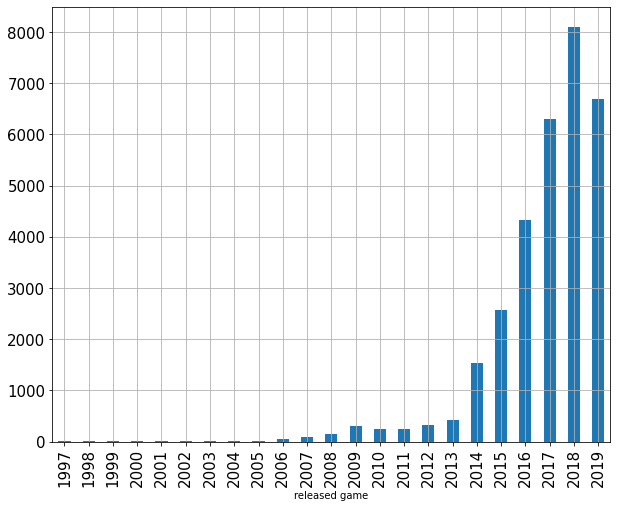

In [6]:
# Time-Series Analysis: Trend
df['year'] = [d.year for d in df.release_date]
CountStatus = pd.value_counts(df['year'].values).sort_index()

# Compensate the number of 2019-released game
last_date = df.sort_values(by='release_date').tail(1)[['release_date']].reset_index()
days = last_date.release_date[0] - pd.to_datetime('2019-01-01')
CountStatus[2019] = CountStatus[2019] * 365 / days.days

CountStatus.plot.bar(xlabel='released game')
CountStatus.plot.bar(grid=True, figsize=(10,8), fontsize=15)

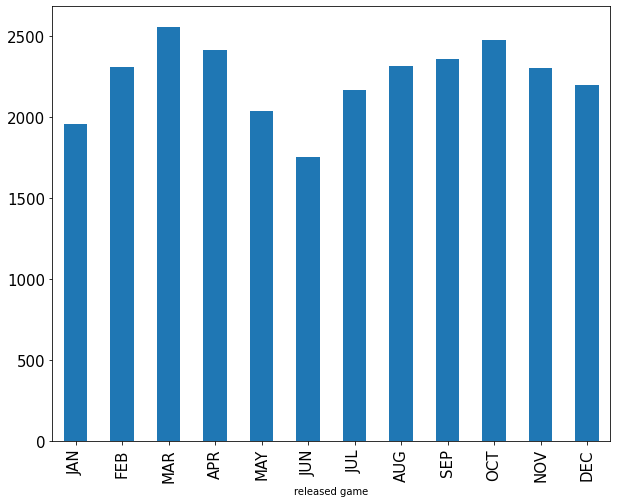

In [7]:
# Time-Series Analysis: Seaonality
df['month'] = [d.month for d in df.release_date]
CountStatus = pd.value_counts(df['month'].values).sort_index()
CountStatus.index = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
CountStatus.plot.bar(xlabel='released game')
CountStatus.plot.bar(figsize=(5,5), fontsize=15)

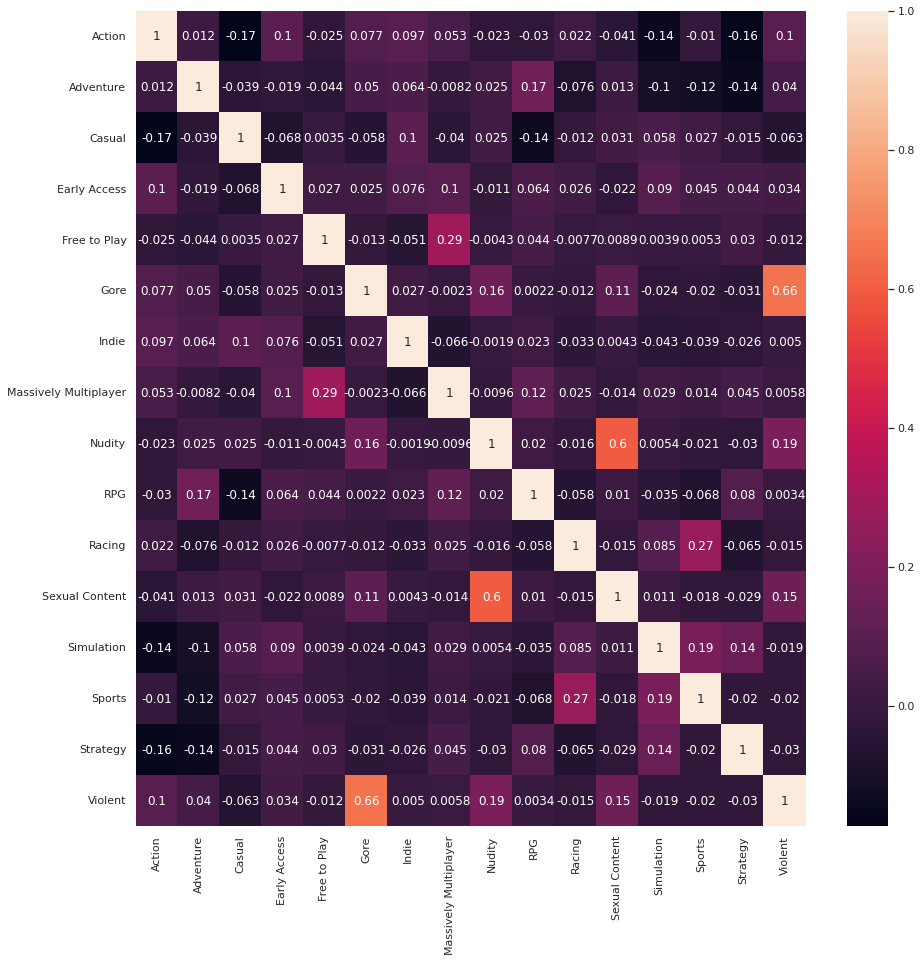

In [8]:
# Correlation between genre_set
corr=df[genre_set].corr()
sns.set(rc = {'figure.figsize':(15,15)})
sns.heatmap(corr, annot=True)

In [9]:
from sklearn.model_selection import train_test_split

# Data Split: Regression(average_playtime, price, owner_level -> rating)
origin_features = ['average_playtime', 'price', 'owner_level']
X_train, X_test, y_train, y_test = train_test_split(df[origin_features], df['rating'], test_size=0.2, random_state=10)

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
predictions = lin_reg.predict(X_test)

# Evaluation
print("MAE: ", mean_absolute_error(y_test, predictions))
print("MSE: ", mean_squared_error(y_test, predictions))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, predictions)))
print("R2: ", r2_score(y_test, predictions))

# Weights
print("\nCoefficient: ", lin_reg.coef_)
print("Constant: ", lin_reg.intercept_)

MAE:  0.1825034019616748
MSE:  0.05369544803081641
RMSE:  0.23172278271852428
R2:  0.011840356077160608

Coefficient:  [4.30933148e-07 2.37918180e-03 1.04271649e-02]
Constant:  0.6922360802261261


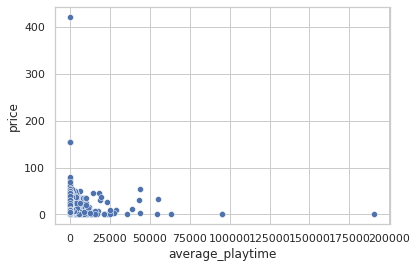

In [75]:
# Preporcessing average_playtime & price
sns.set_style('whitegrid')
sns.scatterplot(x='average_playtime', y='price', data=df[['average_playtime', 'price']])
plt.show()

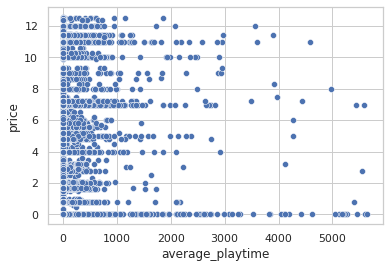

In [76]:
# Handling Outlier
df_IQR = df[['average_playtime', 'price', 'owner_level']]

# Handling Outlier(IQR): price
price_IQR = df.price.quantile(0.75) - df.price.quantile(0.25)
average_playtime_IQR = df.average_playtime.quantile(0.75) - df.average_playtime.quantile(0.25)

# Handling Outlier(z-core): average_playtime (cause: IQR == 0.0)
idx_num2 = df[(df.price > df.price.quantile(0.75) + price_IQR) | 
              (df.price < df.price.quantile(0.25) - price_IQR) | 
              (df.average_playtime > df.average_playtime.mean() + 3 * df.average_playtime.std()) | 
              (df.average_playtime < df.average_playtime.mean() - 3 * df.average_playtime.std())].index
df_IQR = df_IQR.drop(idx_num2)

sns.set_style('whitegrid')
sns.scatterplot(x='average_playtime', y='price', data=df_IQR)
plt.show()



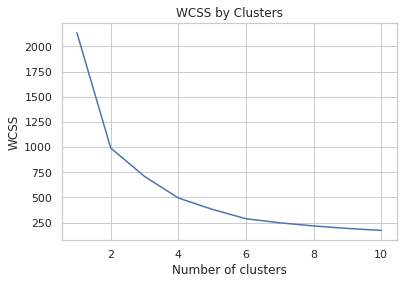

In [13]:
from sklearn.cluster import KMeans
%matplotlib inline

# Scaling(Normalization)
X = df_IQR
for col in X:
 X[col] = (X[col] - X[col].min()) / (X[col].max() - X[col].min())

# WCSS values for 1 to 10 clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X.values)
    wcss.append(kmeans.inertia_)
    
# Plot the WCSS values
plt.plot(range(1, 11), wcss)
plt.title('WCSS by Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [14]:
from sklearn.cluster import KMeans

# k-Means: Create a model based on 4 clusters
model = KMeans(n_clusters=4,random_state=0)
km_clusters = model.fit_predict(X)

X_withCluster = X.copy()
X_withCluster['km_clusters'] = km_clusters

In [15]:
from sklearn.cluster import AgglomerativeClustering

# Agglomerative: Create a model based on 4 clusters
agg_model = AgglomerativeClustering(n_clusters=4, linkage='average')
agg_clusters = agg_model.fit_predict(X)

X_withCluster['agg_clusters'] = agg_clusters

In [16]:
from sklearn.metrics import silhouette_score

# Clustering Evaluation: Silhoutte
print('silhouette of kMeans: %f'%silhouette_score(X,X_withCluster['km_clusters']))
print('silhouette of Hierarchical Clustering: %f'%silhouette_score(X,X_withCluster['agg_clusters']))

silhouette of kMeans: 0.522200
silhouette of Hierarchical Clustering: 0.507743


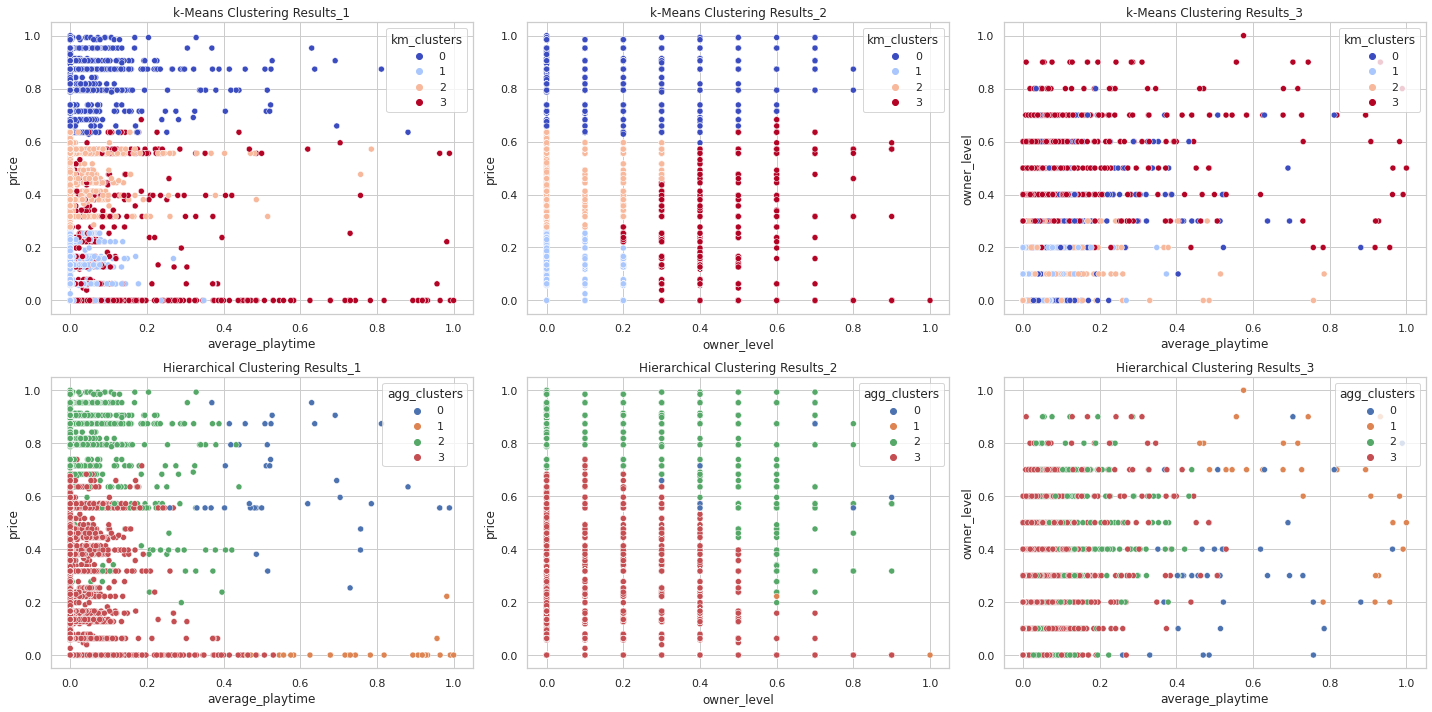

In [17]:
# Scatterplot for Clustering and Features
fig, ax = plt.subplots(2, 3, figsize=(20,10))

sns.scatterplot(x='average_playtime', y='price', data=X_withCluster, hue='km_clusters',
           palette='coolwarm', ax=ax[0, 0])
sns.scatterplot(x='average_playtime', y='price', data=X_withCluster, hue='agg_clusters',
           palette='deep', ax=ax[1, 0])
sns.scatterplot(x='owner_level', y='price', data=X_withCluster, hue='km_clusters',
           palette='coolwarm', ax=ax[0, 1])
sns.scatterplot(x='owner_level', y='price', data=X_withCluster, hue='agg_clusters',
           palette='deep', ax=ax[1, 1])
sns.scatterplot(x='average_playtime', y='owner_level', data=X_withCluster, hue='km_clusters',
           palette='coolwarm', ax=ax[0, 2])
sns.scatterplot(x='average_playtime', y='owner_level', data=X_withCluster, hue='agg_clusters',
           palette='deep', ax=ax[1, 2])

ax[0, 0].set(title='k-Means Clustering Results_1')
ax[1, 0].set(title='Hierarchical Clustering Results_1')
ax[0, 1].set(title='k-Means Clustering Results_2')
ax[1, 1].set(title='Hierarchical Clustering Results_2')
ax[0, 2].set(title='k-Means Clustering Results_3')
ax[1, 2].set(title='Hierarchical Clustering Results_3')

fig.tight_layout()

plt.show()

In [18]:
# Use agg_cluster for classification target
df = pd.concat([df,X_withCluster[['agg_clusters']]], axis=1)

# Drop NaN (Outliear)
df_noNA = df.dropna()
df_noNA

,appid,release_date,publisher,required_age,genres,rating,total_ratings,average_playtime,median_playtime,owners,owner_level,price,Action,Adventure,Casual,Early Access,Free to Play,Gore,Indie,Massively Multiplayer,Nudity,RPG,Racing,Sexual Content,Simulation,Sports,Strategy,Violent,year,month,agg_clusters
1,20,1999-04-01,Valve,0,Action,0.839787,3951,277,62,7500000,8,3.99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1999,4,2.0
2,30,2003-05-01,Valve,0,Action,0.895648,3814,187,34,7500000,8,3.99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2003,5,2.0
3,40,2001-06-01,Valve,0,Action,0.826623,1540,258,184,7500000,8,3.99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2001,6,2.0
4,50,1999-11-01,Valve,0,Action,0.947996,5538,624,415,7500000,8,3.99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1999,11,2.0
5,60,2000-11-01,Valve,0,Action,0.801278,3442,175,10,7500000,8,3.99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000,11,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,2019-04-24,SHEN JIAWEI,0,Adventure;Casual;Indie,1.000000,3,0,0,10000,0,2.09,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,4,3.0
27071,1065570,2019-04-23,BekkerDev Studio,0,Action;Adventure;Indie,0.888889,9,0,0,10000,0,1.69,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,4,3.0
27072,1065650,2019-04-24,EntwicklerX,0,Action;Casual;Indie,0.000000,1,0,0,10000,0,3.99,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,4,3.0
27073,1066700,2019-04-17,Alawar Entertainment,0,Adventure;Casual;Indie,1.000000,2,0,0,10000,0,5.19,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,4,3.0


In [19]:
# Classification without Balancing Data
drop_attribute = ['appid', 'release_date', 'publisher', 'genres', 'average_playtime', 
                  'median_playtime', 'owners', 'owner_level', 'price', 'month', 'agg_clusters']
features = np.setdiff1d(df.columns, drop_attribute)

# Data Split: Classification(Features -> agg_clusters)
X1_train, X1_test, y1_train, y1_test = train_test_split(df_noNA[features], df_noNA['agg_clusters'], 
                                                    test_size=0.2, random_state=0)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models = []

# Logistic Regression
log_reg1 = LogisticRegression(max_iter=5000)
log_reg1.fit(X1_train, y1_train)
models.append((0, 'Logistic Regression', log_reg1))

# K-Nearest Neighbor Classification
kNN1 = KNeighborsClassifier(n_neighbors=5)
kNN1.fit(X1_train, y1_train)
models.append((1, '        kNN        ', kNN1))

# Gaussian Naive Bayes
GNB1 = GaussianNB()
GNB1.fit(X1_train, y1_train)
models.append((2, '    Naive Bayes    ', GNB1))

# Decision Tree Classification
DTC1 = DecisionTreeClassifier()
DTC1 = DTC1.fit(X1_train, y1_train)
models.append((3, '   Decision Tree   ', DTC1))

# Random Forest Classification
RFC1 = RandomForestClassifier()
RFC1 = RFC1.fit(X1_train, y1_train)
models.append((4, '   Random Forest   ', RFC1))

# Support Vector Machine
svm1 = SVC(gamma='auto')
svm1.fit(X1_train, y1_train)
models.append((5, '        SVM        ', svm1))

SVC(gamma='auto')


/* =============== Logistic Regression ================ */

Accuracy: 0.865925304238355
Precision: 0.865925304238355
Recall: 0.865925304238355
F1-Score: 0.865925304238355 

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         6
         2.0       0.70      0.02      0.04       636
         3.0       0.87      1.00      0.93      4116

   micro avg       0.87      0.87      0.87      4758
   macro avg       0.52      0.34      0.32      4758
weighted avg       0.84      0.87      0.81      4758


/* ===============         kNN         ================ */

Accuracy: 0.8541754091481326
Precision: 0.8541754091481326
Recall: 0.8541754091481326
F1-Score: 0.8541754091481326 

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.00      0.00      0.00         6
         2.0       0.36      0.09      0.15       636
         3.0       0.87      0.97      0.92      4

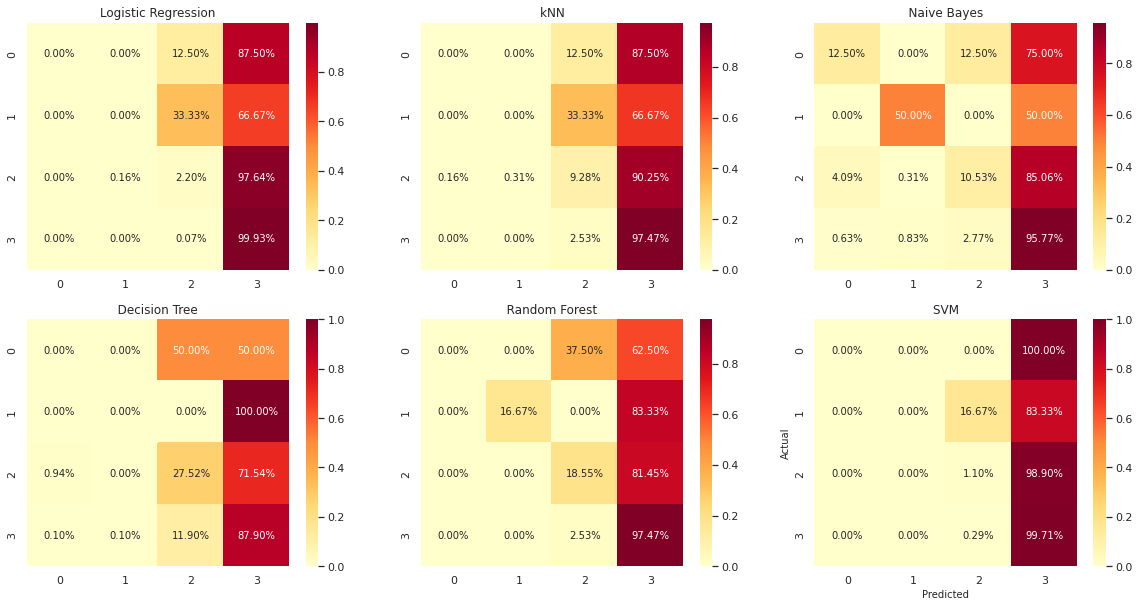

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Evaluation
fig, ax = plt.subplots(2, 3, figsize=(20,10))

for i, name, model in models:
  predictions = model.predict(X1_test)
  cm = confusion_matrix(y1_test, predictions)
  print('\n/* =============== {} ================ */'.format(name))
  print("\nAccuracy:", accuracy_score(y1_test, predictions))
  print("Precision:", precision_score(y1_test, predictions, average='micro'))
  print("Recall:", recall_score(y1_test, predictions, average='micro'))
  print("F1-Score:", f1_score(y1_test, predictions, average='micro'),"\n")
  print(classification_report(y1_test, predictions, labels=np.unique(predictions)))

# Confusion Matrix
  _cm = [[],[],[],[]]
  for m in np.arange(len(cm)):
    tmp = np.sum(cm[m])
    for n in np.arange(len(cm)):
      _cm[m].append(float(cm[m, n]  * 1.0 / tmp))
  
  sns.heatmap(_cm, annot=True, fmt='.2%', cmap='YlOrRd', ax=ax[int(i / 3), int(i % 3)])
  plt.xlabel('Predicted', fontsize=10)
  plt.ylabel('Actual', fontsize=10)
  ax[int(i / 3), int(i % 3)].set(title=name)

plt.show()

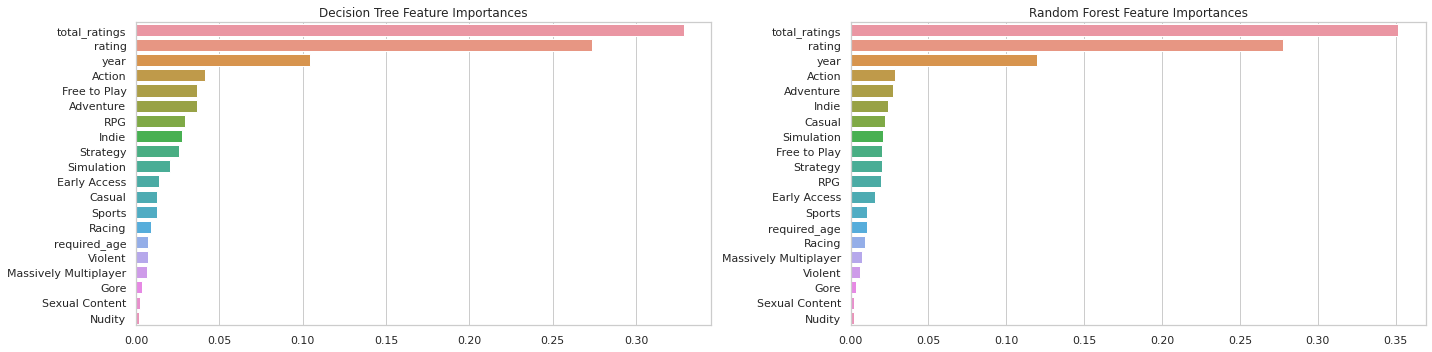

In [62]:
# TOP_20 feature_importance for DTC & RFC
f_importances_DTC1 = pd.Series(DTC1.feature_importances_, index=X1_train.columns)
f_top20_DTC1 = f_importances_DTC1.sort_values(ascending=False)[:20]
f_importances_RFC1 = pd.Series(RFC1.feature_importances_, index=X1_train.columns)
f_top20_RFC1 = f_importances_RFC1.sort_values(ascending=False)[:20]

fig, ax = plt.subplots(1, 2, figsize=(20,5))

sns.barplot(x=f_top20_DTC1, y=f_top20_DTC1.index, ax=ax[0])
ax[0].set(title='Decision Tree Feature Importances')
sns.barplot(x=f_top20_RFC1, y=f_top20_RFC1.index, ax=ax[1])
ax[1].set(title='Random Forest Feature Importances')

fig.tight_layout()

plt.show()

In [57]:
from imblearn.over_sampling import SMOTE

# Classification with Balancing Data
smote = SMOTE(random_state=0)
X_sm, y_sm = smote.fit_resample(df_noNA[features], df_noNA['agg_clusters'])

# Data Split: Classification(Features -> agg_clusters)
X2_train, X2_test, y2_train, y2_test = train_test_split(X_sm, y_sm, 
                                                        test_size=0.2, random_state=0)

In [58]:
# Logistic Regression
log_reg2 = LogisticRegression(max_iter=5000)
log_reg2.fit(X2_train, y2_train)

# K-Nearest Neighbor Classification
kNN2 = KNeighborsClassifier(n_neighbors=5)
kNN2.fit(X2_train, y2_train)

# Gaussian Naive Bayes
GNB2 = GaussianNB()
GNB2.fit(X2_train, y2_train)

# Decision Tree Classification
DTC2 = DecisionTreeClassifier()
DTC2 = DTC2.fit(X2_train, y2_train)

# Random Forest Classification
RFC2 = RandomForestClassifier()
RFC2 = RFC2.fit(X2_train, y2_train)

# Support Vector Machine
svm2 = SVC(gamma='auto')
svm2.fit(X2_train, y2_train)

SVC(gamma='auto')


/* =============== Logistic Regression ================ */

Accuracy: 0.6404076738609112
Precision: 0.6404076738609112
Recall: 0.6404076738609112
F1-Score: 0.6404076738609112 

              precision    recall  f1-score   support

         0.0       0.64      0.64      0.64      4257
         1.0       0.95      0.91      0.93      4253
         2.0       0.46      0.50      0.48      4102
         3.0       0.52      0.50      0.51      4068

    accuracy                           0.64     16680
   macro avg       0.64      0.64      0.64     16680
weighted avg       0.65      0.64      0.64     16680


/* ===============         kNN         ================ */

Accuracy: 0.7847122302158274
Precision: 0.7847122302158274
Recall: 0.7847122302158274
F1-Score: 0.7847122302158274 

              precision    recall  f1-score   support

         0.0       0.75      0.84      0.79      4257
         1.0       0.81      0.87      0.84      4253
         2.0       0.73      0.82      0.77   

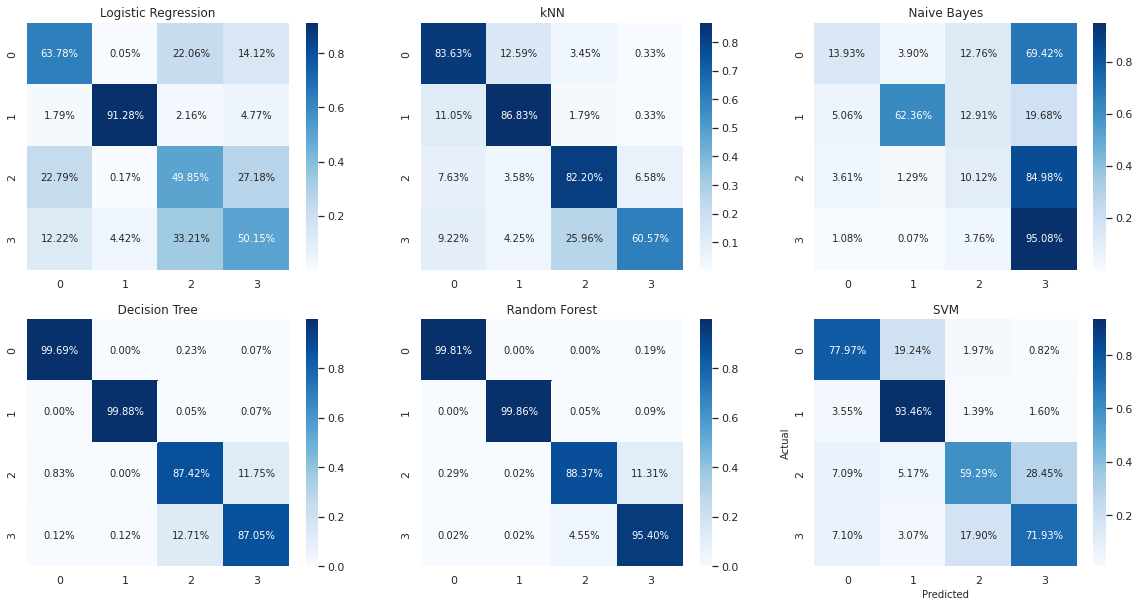

In [59]:
# Evaluation
fig, ax = plt.subplots(2, 3, figsize=(20,10))

for i, name, model in models:
  predictions = model.predict(X2_test)
  cm = confusion_matrix(y2_test, predictions)
  print('\n/* =============== {} ================ */'.format(name))
  print("\nAccuracy:", accuracy_score(y2_test, predictions))
  print("Precision:", precision_score(y2_test, predictions, average='micro'))
  print("Recall:", recall_score(y2_test, predictions, average='micro'))
  print("F1-Score:", f1_score(y2_test, predictions, average='micro'),"\n")
  print(classification_report(y2_test, predictions, labels=np.unique(predictions)))

# Confusion Matrix
  _cm = [[],[],[],[]]
  for m in np.arange(len(cm)):
    tmp = np.sum(cm[m])
    for n in np.arange(len(cm)):
      _cm[m].append(float(cm[m, n]  * 1.0 / tmp))
  
  sns.heatmap(_cm, annot=True, fmt='.2%', cmap='Blues', ax=ax[int(i / 3), int(i % 3)])
  plt.xlabel('Predicted', fontsize=10)
  plt.ylabel('Actual', fontsize=10)
  ax[int(i / 3), int(i % 3)].set(title=name)

plt.show()

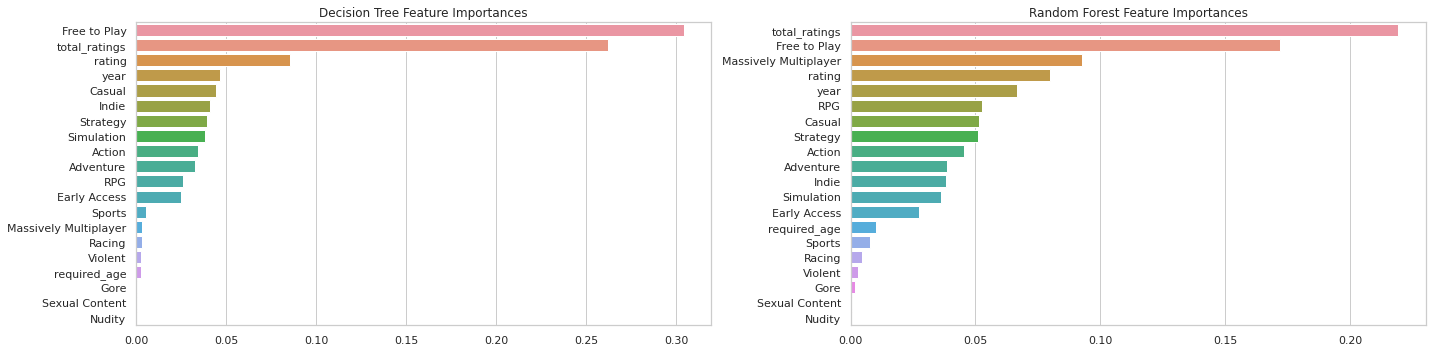

In [63]:
# TOP_20 feature_importance for DTC & RFC
f_importances_DTC2 = pd.Series(DTC2.feature_importances_, index=X2_train.columns)
f_top20_DTC2 = f_importances_DTC2.sort_values(ascending=False)[:20]
f_importances_RFC2 = pd.Series(RFC2.feature_importances_, index=X2_train.columns)
f_top20_RFC2 = f_importances_RFC2.sort_values(ascending=False)[:20]

fig, ax = plt.subplots(1, 2, figsize=(20,5))

sns.barplot(x=f_top20_DTC2, y=f_top20_DTC2.index, ax=ax[0])
ax[0].set(title='Decision Tree Feature Importances')
sns.barplot(x=f_top20_RFC2, y=f_top20_RFC2.index, ax=ax[1])
ax[1].set(title='Random Forest Feature Importances')

fig.tight_layout()

plt.show()